Tests for "forcing amplitude constraint" for PD

In [13]:
%%capture
%load_ext autoreload
%autoreload 2+

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
exec(open('../codes/zernike.py'))
exec(open('../codes/pr.py'))
exec(open('../codes/util.py'))
%matplotlib inline

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

---
### 10x defocusing
... and another set of true images

In [14]:
coeff2 = [0,1,0,0,0,1,2,0,2,1.5,2,0,0,0,0]
coeff1 = [0]*15 #np.random.random(15)
P,P_,F,F_ = true_imgs(Npix=128,coeff1=coeff1,coeff2=coeff2,oversamp=2)

In [15]:
defocus = 10
[P10,P_10,F10,F_10], \
[D10,D_10,Fd10,F_d10] = true_imgs_defocus(Npix=128,oversamp=2,
                                          coeff1=coeff1,
                                          coeff2=coeff2,
                                          defocus=defocus)

In [16]:
test10 = PR(pup=P10,foc=F10,oversamp=2)
test10(foc_defoc=[F10,Fd10])

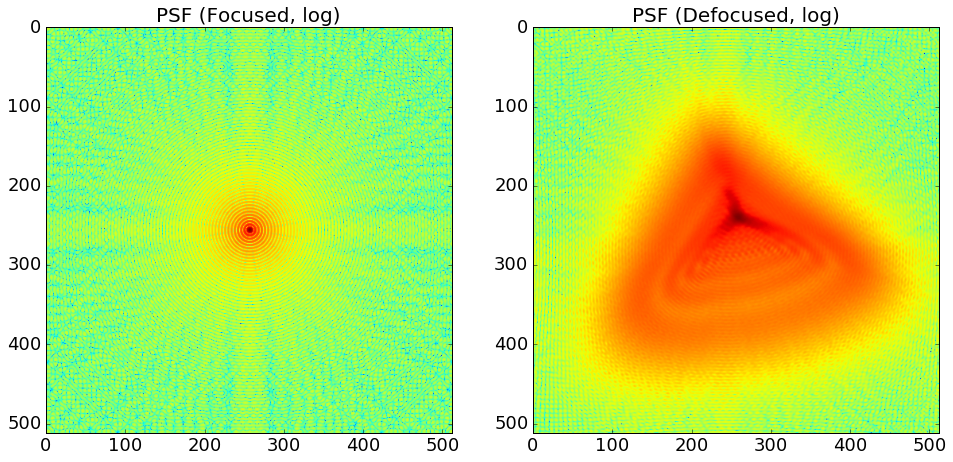

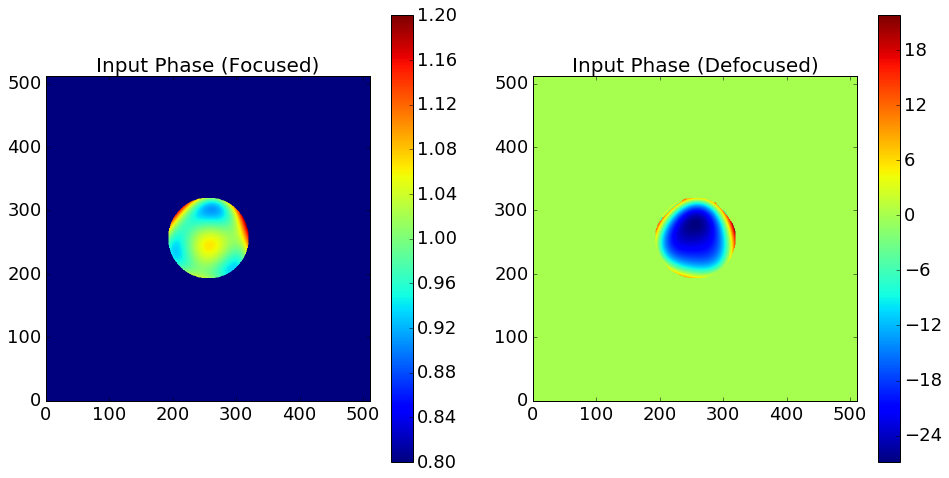

In [6]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(np.sqrt(test10.foc_foc),norm=LogNorm()); plt.title('PSF (Focused, log)')
plt.subplot(122); plt.imshow(np.sqrt(test10.foc_def),norm=LogNorm()); plt.title('PSF (Defocused, log)')

plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(unwrap_phase(np.angle(P_10)),origin='lower'); 
plt.colorbar(); plt.title('Input Phase (Focused)'); plt.clim(0.8,1.2)
plt.subplot(122); plt.imshow(unwrap_phase(np.angle(D_10)),origin='lower'); 
plt.colorbar(); plt.title('Input Phase (Defocused)')

#### 1000 iterations and random initial guess

Caution: Pupil image is not used for constraints.


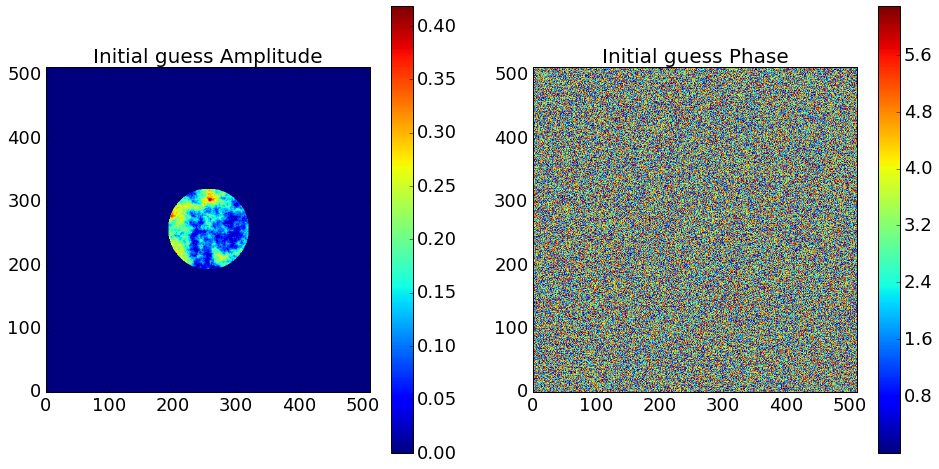

Current step                    : 100
Error (of focused Fourier plane): 4.20e-03
Current step                    : 200
Error (of focused Fourier plane): 4.21e-03
Current step                    : 300
Error (of focused Fourier plane): 4.21e-03
Current step                    : 400
Error (of focused Fourier plane): 4.28e-03
Current step                    : 500
Error (of focused Fourier plane): 4.23e-03
Current step                    : 600
Error (of focused Fourier plane): 4.24e-03
Current step                    : 700
Error (of focused Fourier plane): 4.27e-03
Current step                    : 800
Error (of focused Fourier plane): 4.22e-03
Current step                    : 900
Error (of focused Fourier plane): 4.26e-03
Current step                    : 1000
Error (of focused Fourier plane): 4.29e-03
-----------------------
First iteration error: 1.22e-02
Final step : 1000
Final Error: 4.29e-03


In [17]:
PD_ER_pup10, \
PD_ER_foc10, \
PD_ER_errlist10, \
PD_ER_pup10_proj, \
PD_ER_errpuplist10 = test10.PD_ER(defocus=defocus,init='random',
                                  iterlim=1000,
                                  force_only_phase=True)

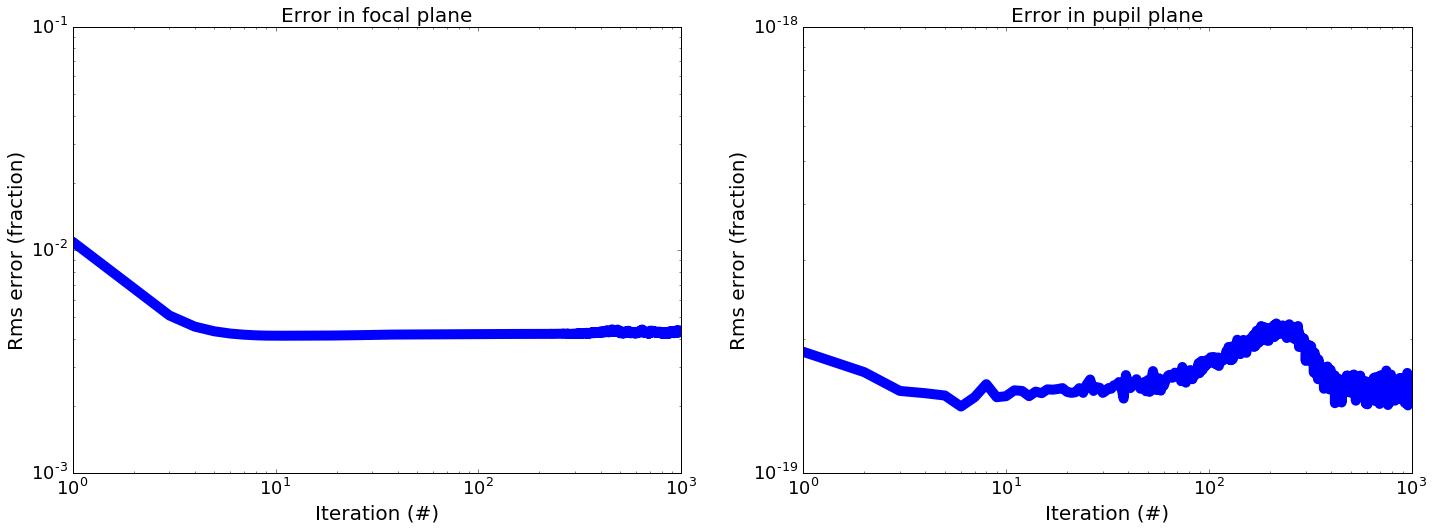

In [18]:
plot_errlist(PD_ER_errlist10,PD_ER_errpuplist10)

1000 iterations might be too many. The apparent minimum has been reached almost instantly (<100 iterations)

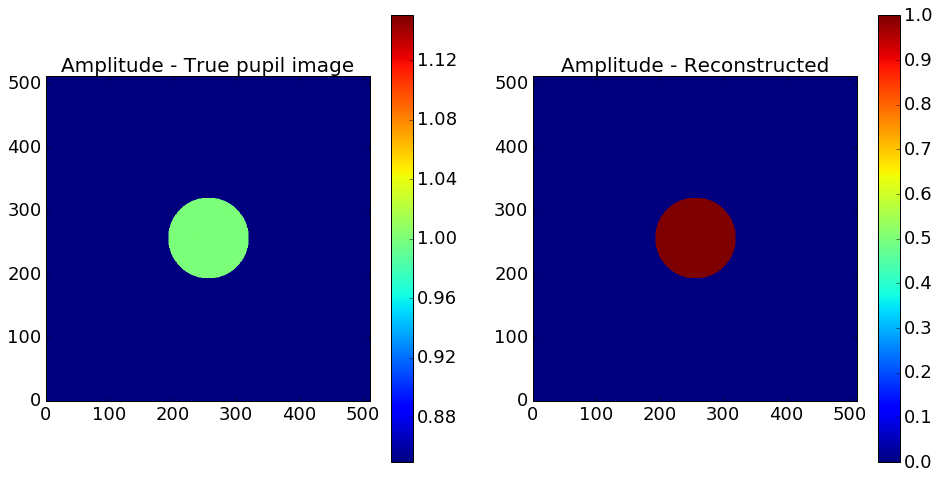

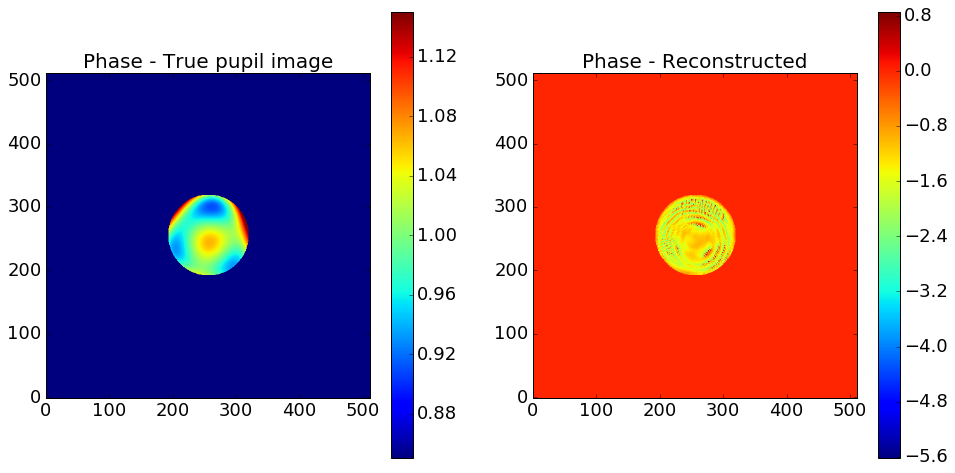

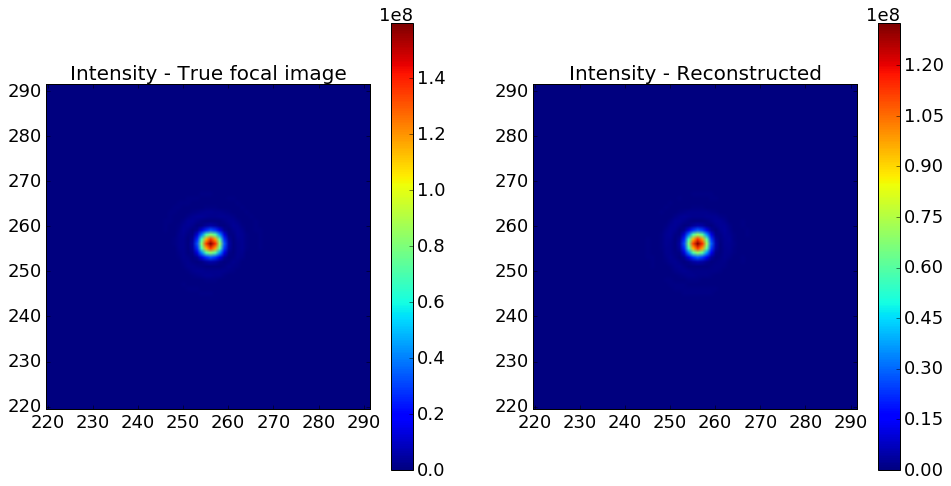

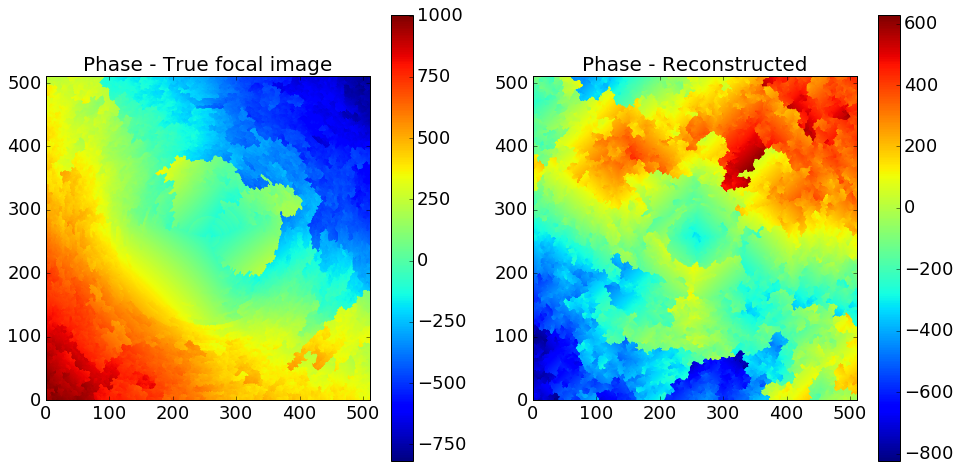

In [19]:
plot_recon(P_10,F_10,PD_ER_pup10_proj,PD_ER_foc10,max_abrAmp=0.15,max_abrPha=0.15)

Ripples...

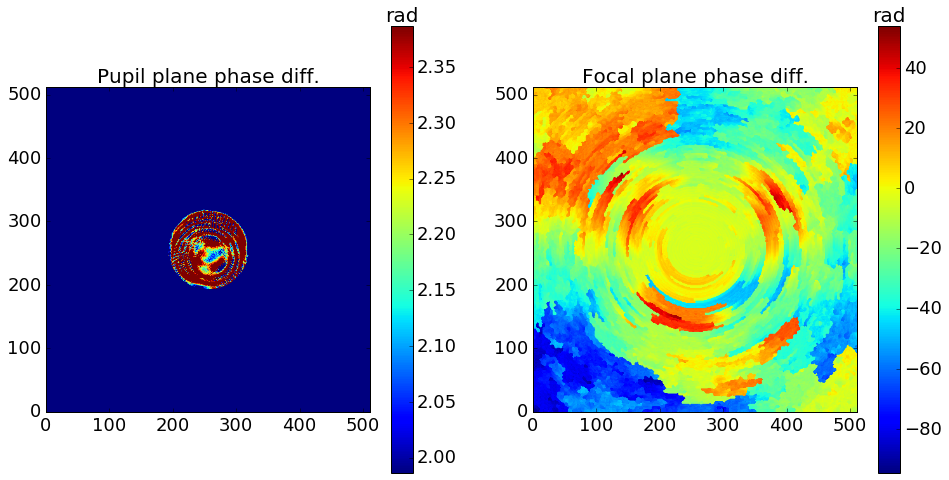

In [20]:
plot_phase_residual(P_10,F_10,PD_ER_pup10_proj,PD_ER_foc10)

#### How about 100 iterations?

Caution: Pupil image is not used for constraints.


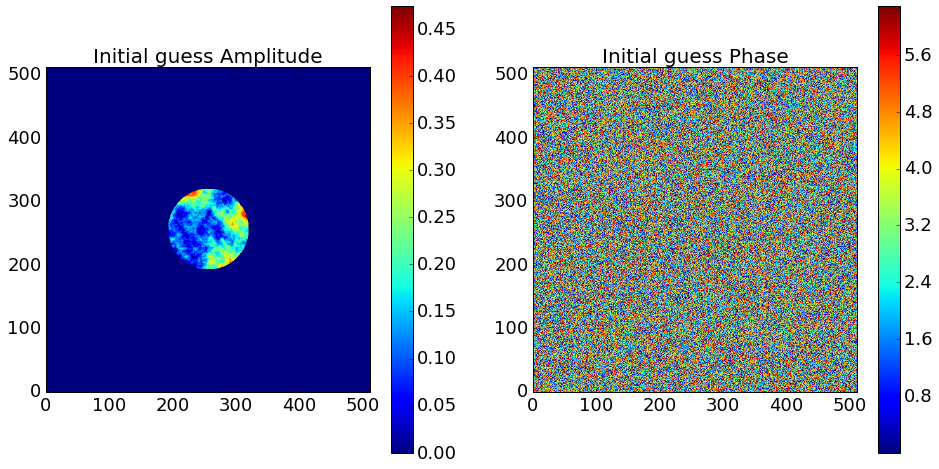

Current step                    : 100
Error (of focused Fourier plane): 4.15e-03
-----------------------
First iteration error: 1.23e-02
Final step : 100
Final Error: 4.15e-03


In [21]:
PD_ER_pup100, \
PD_ER_foc100, \
PD_ER_errlist100, \
PD_ER_pup100_proj, \
PD_ER_errpuplist100 = test10.PD_ER(defocus=defocus,init='random',
                                   iterlim=100,
                                   force_only_phase=True)

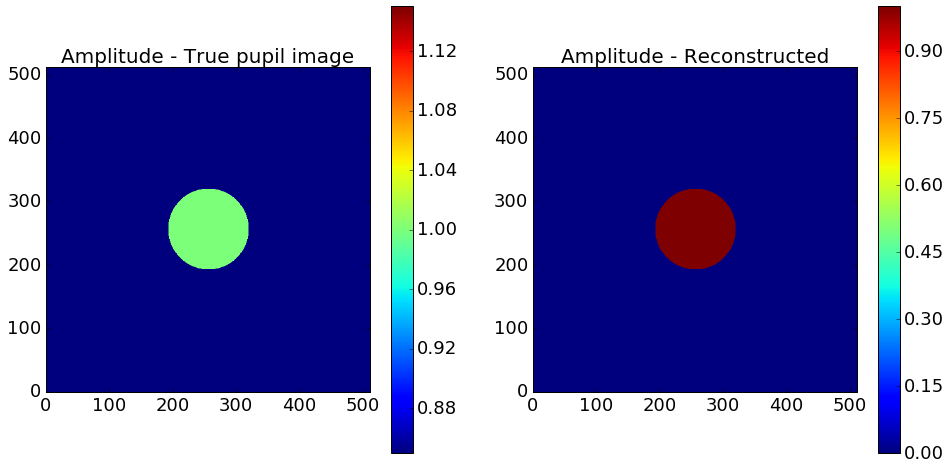

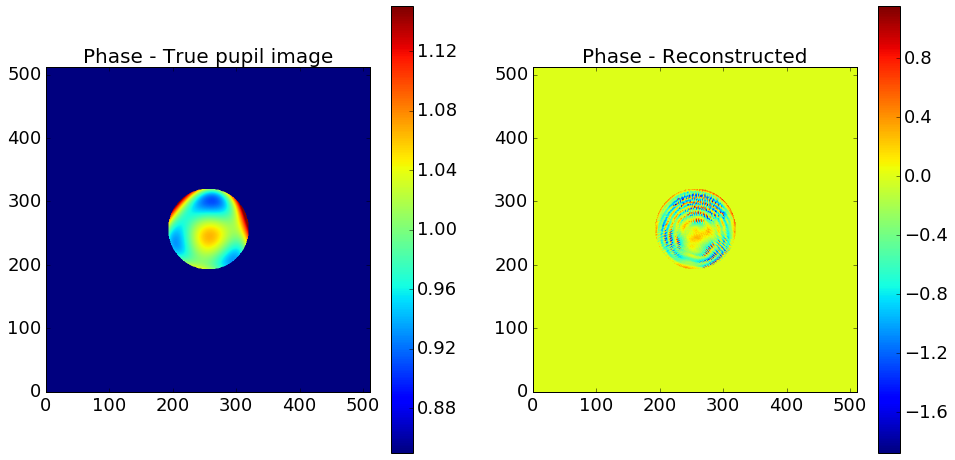

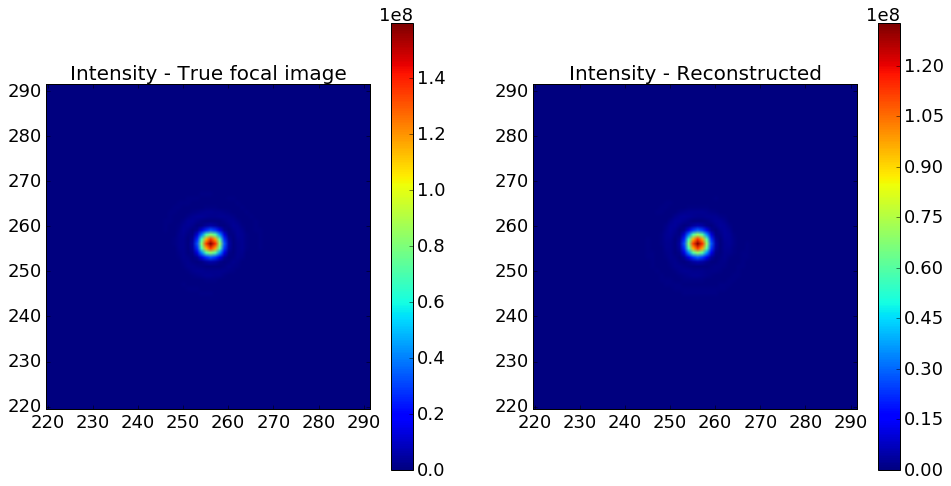

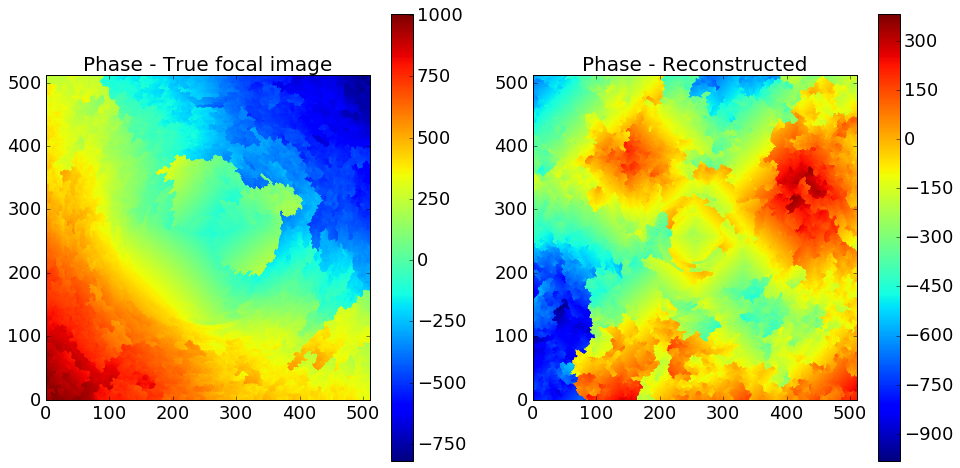

In [22]:
plot_recon(P_10,F_10,PD_ER_pup100_proj,PD_ER_foc100,max_abrAmp=0.15,max_abrPha=0.15)

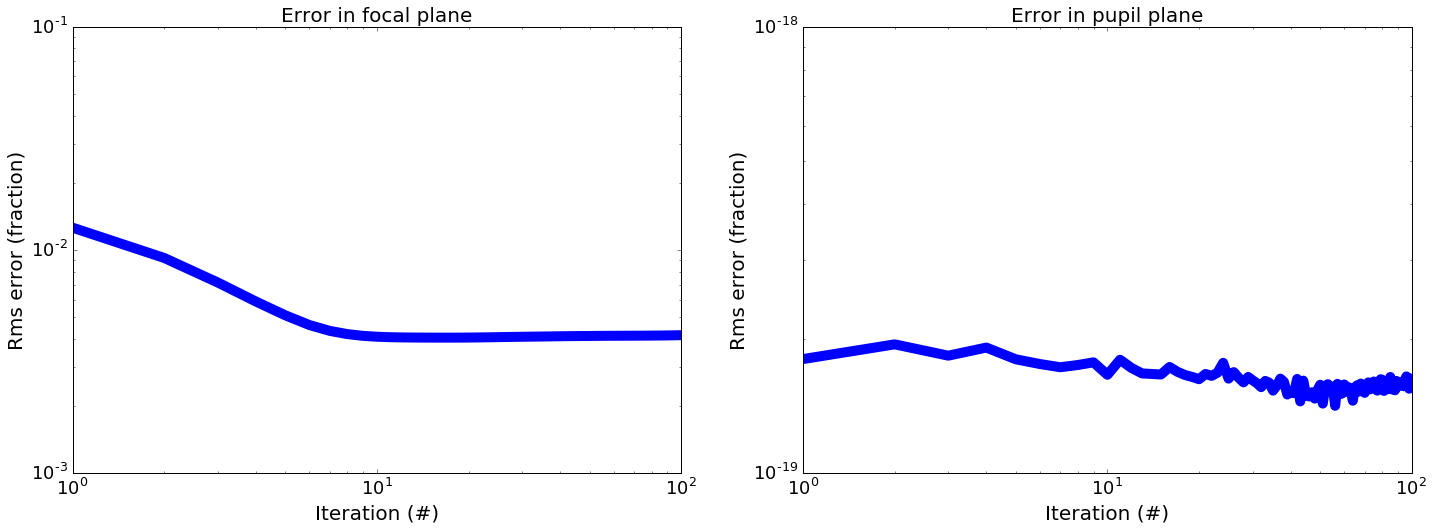

In [23]:
plot_errlist(PD_ER_errlist100,PD_ER_errpuplist100)

Did not help much. Ripples could not be suppressed (though the big picture is right)

#### Crude masking: remove outer (high-f) part by applying a mask
To check if we can recover the "main" features...

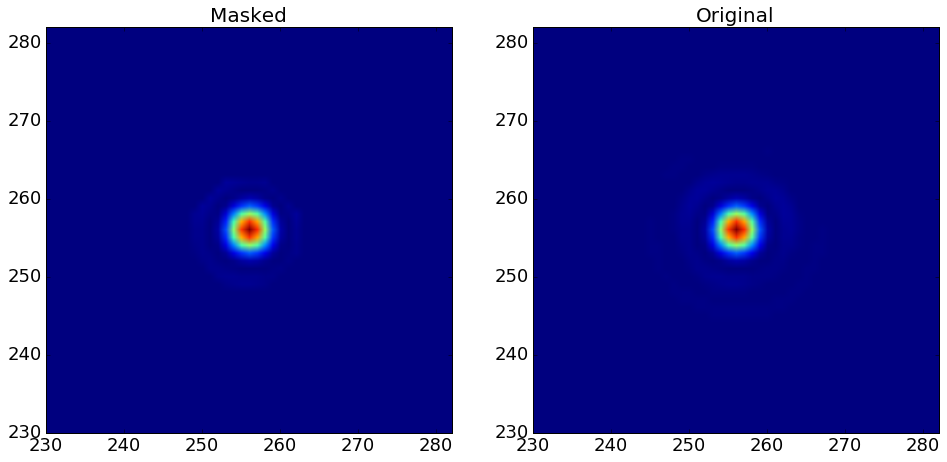

In [24]:
origin_int = abs(PD_ER_foc100)**2
masked_int = ccmask(origin_int,radius=7)
masked_foc = ccmask(PD_ER_foc100,radius=7)

plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(masked_int,origin='lower'); plt.xlim(230,282); plt.ylim(230,282); plt.title('Masked')
plt.subplot(122); plt.imshow(origin_int,origin='lower'); plt.xlim(230,282); plt.ylim(230,282); plt.title('Original')

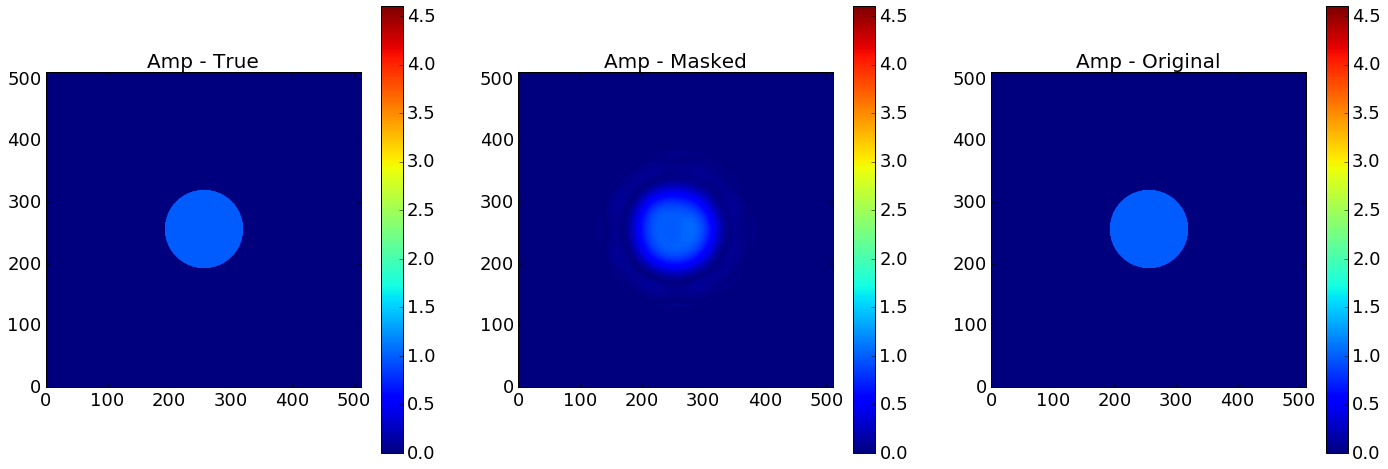

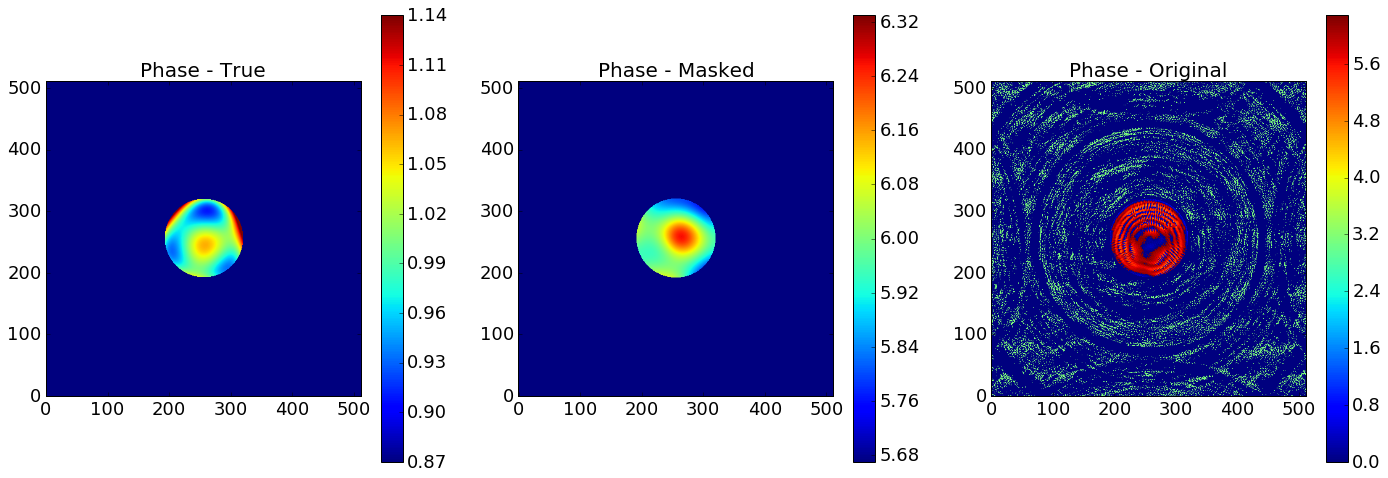

In [33]:
from numpy.fft import ifft2, ifftshift
new_pupil = ifft2(ifftshift(masked_foc))

plt.figure(figsize=(24,8))
plt.subplot(131); plt.imshow(abs(P_),origin='lower'); 
plt.title('Amp - True'); plt.colorbar(); plt.clim(0,4.6)
plt.subplot(132); plt.imshow(ccmask(abs(new_pupil),128),origin='lower'); 
plt.title('Amp - Masked'); plt.colorbar(); plt.clim(0,4.6)
plt.subplot(133); plt.imshow(abs(PD_ER_pup100),origin='lower'); 
plt.title('Amp - Original'); plt.colorbar(); plt.clim(0,4.6)

plt.figure(figsize=(24,8))
plt.subplot(131); plt.imshow(ccmask(np.mod(np.angle(P_),2*np.pi),radius=64),origin='lower'); 
plt.title('Phase - True'); plt.colorbar(); plt.clim(0.87,1.14)
plt.subplot(132); plt.imshow(ccmask(np.mod(np.angle(new_pupil),2*np.pi),radius=64),origin='lower'); 
plt.title('Phase - Masked'); plt.colorbar(); plt.clim(5.67,6.33)
plt.subplot(133); plt.imshow(np.mod(np.angle(PD_ER_pup100),2*np.pi),origin='lower'); 
plt.title('Phase - Original'); plt.colorbar(); plt.clim(0,2*np.pi)

Unfortunately the outermost parts (the two red ridges near the edge) got smoothed out as well...

---
## Sanity check
What if the initial guess happens to be "correct"?
_Should get back exactly the same true images_

In [8]:
test1 = PR(pup=P10,foc=F10,oversamp=2)
test1(foc_defoc=[F10,Fd10])

Caution: Pupil image is not used for constraints.


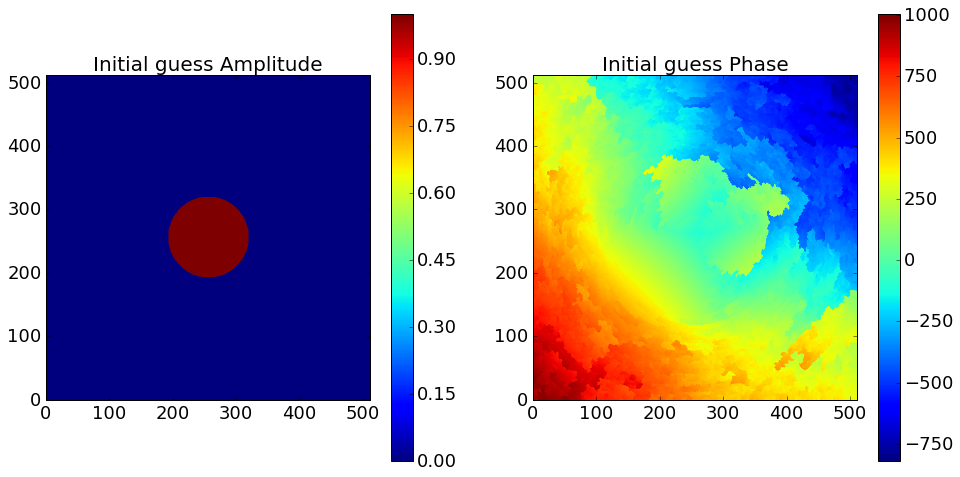

-----------------------
First iteration error: 1.20e-08
Final step : 1
Final Error: 1.20e-08


In [10]:
PD_ER_pup1, \
PD_ER_foc1, \
PD_ER_errlist1, \
PD_ER_pup1_proj, \
PD_ER_errpuplist1 = test10.PD_ER(defocus=defocus,init='test',
                                 true_phasorP=F_10,true_phasorF=F_d10,
                                 force_only_phase=True)

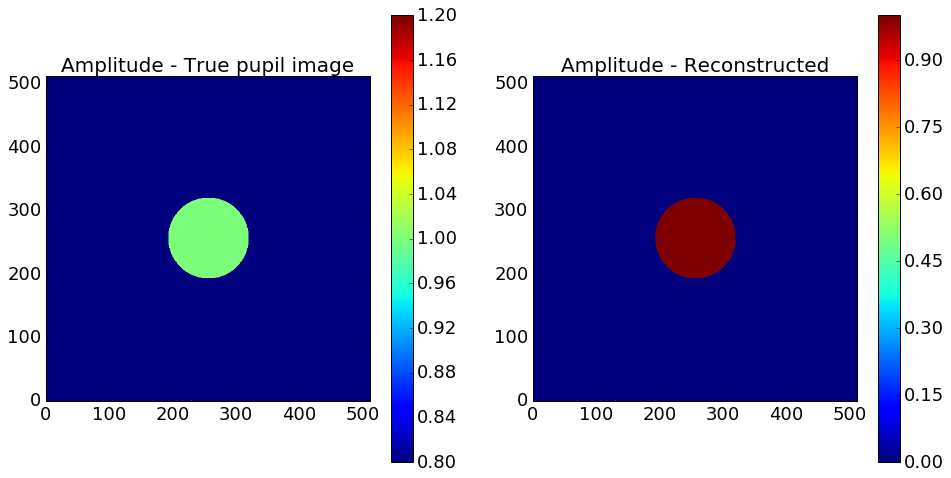

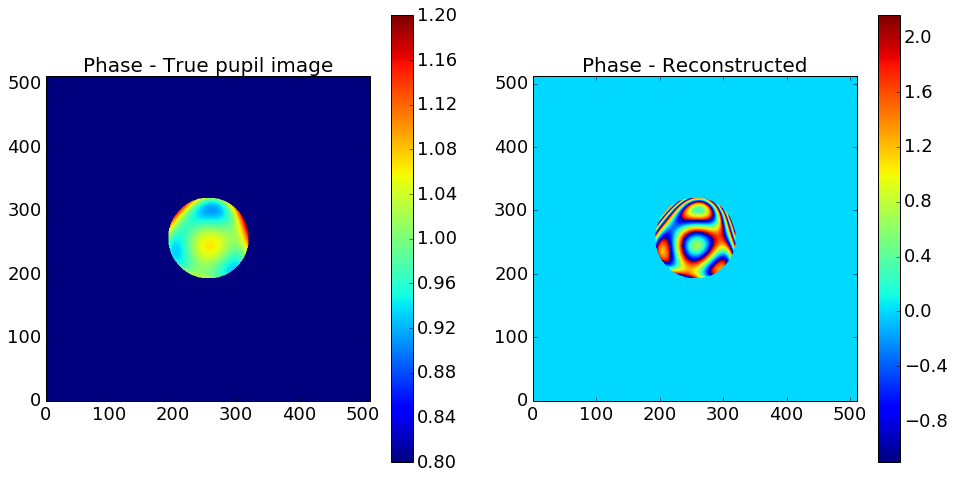

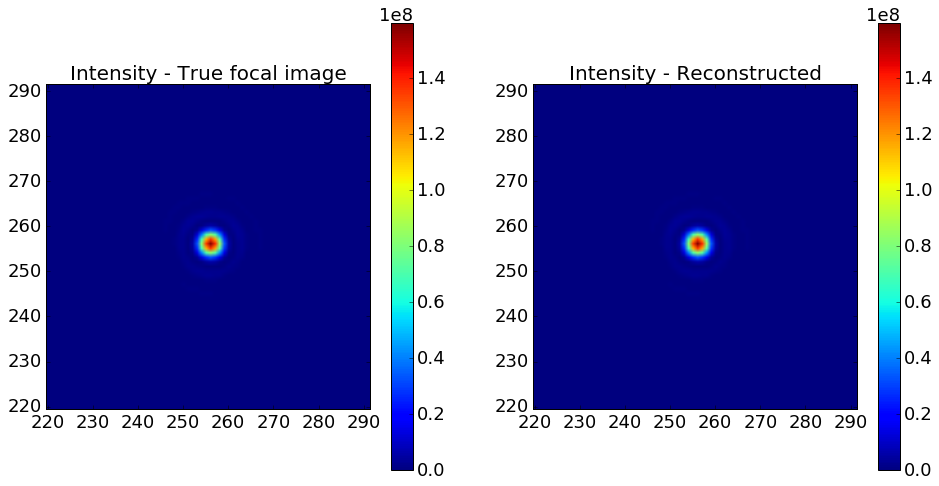

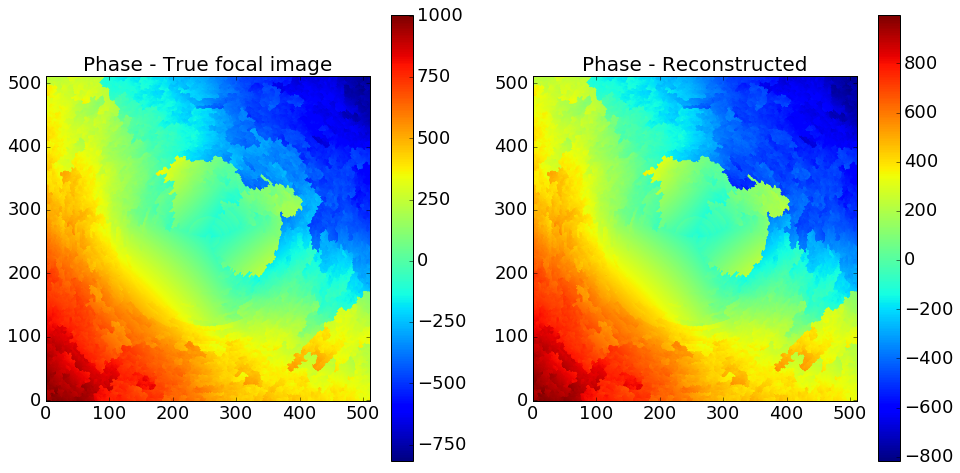

In [12]:
plot_recon(P_1,F_1,PD_ER_pup1_proj,PD_ER_foc1)